In [1]:
import os, sys
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
from config import *
from src.dataset import *

# Convolutional SNN

Краткий туториал по устройству свертки в импульснах нейронных сетях.

# 1. Подготовка набора данных

## 1.1. Импорт датасета

In [2]:
emg, label = folder_extract('../'+FOLDER_PATH, exercises=EXERCISES, myo_pref=MYO_PREF)
all_g = gestures(emg, label, targets=GESTURE_INDEXES_MAIN)

train_g, test_g = train_test_split(all_g, split_size=0.2, rand_seed=GLOBAL_SEED)

X_train_raw, y_train = apply_window(train_g, window=WINDOW_SIZE, step=STEP_SIZE)
X_test_raw,  y_test  = apply_window(test_g,  window=WINDOW_SIZE, step=STEP_SIZE)

## 1.2. Стандартизация и подготовка к размерности модели

In [3]:
means = X_train_raw.mean(axis=(0, 2))       # (channels,)
stds  = X_train_raw.std(axis=(0, 2)) + 1e-8

def standardize(X):
    return (X - means[None,:,None]) / stds[None,:,None]

Xs_train = standardize(X_train_raw)
Xs_test = standardize(X_test_raw)

In [4]:
def prepare(X):
    Xt = np.transpose(X, (0, 2, 1))   # [N, window, channels]
    sel = Xt[..., CHANNELS]           # отбор каналов
    return sel[..., np.newaxis].astype(np.float32)

X_train = prepare(Xs_train)  # Готовые данные
X_test = prepare(Xs_test)

In [5]:
X_train = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)

In [6]:
X_train.shape    # (кол-во окон, 1, количество каналов, размерность окна)

torch.Size([32941, 1, 52, 8])

## 1.3. Определение загрузчиков данных

In [7]:
from torch.utils.data import DataLoader

train_dataset = SpikingEMGDataset(X=X_train, y=y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

test_dataset = SpikingEMGDataset(X=X_test, y=y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 2. Конвертация исходных данных в серии спайков

Одной из отличительных особенностей импульсных нейронных сетей является возможность работать с последовательностями бинарных данных напрямую. Однако для конвертации исходных данных в серии спайков важно понимать структуру данных. Так, для MNIST оптимальным выбором будет `ConstantCurrentLIFEncoder()`, который рассматривает градацию серого (пикселей) как постоянный ток. 

В `Norse` есть следующие энкодеры:

- `ConstantCurrentLIFEncoder`

- `PoissonEncoder`

- `PopulationEncoder`

- `SignedPoissonEncoder`

- `SpikeLatencyEncoder`

- `SpikeLatencyLIFEncoder`

Рассмотрим некоторые из этих энкодеров для преобразования окон ЭМГ сигналов в последовательность спайков.

## 2.1. `ConstantCurrentLIFEncoder`

In [42]:
T = 32    # Длина последовательности

In [50]:
i = np.random.randint(0, 10000)
window_example = X_train[i]
window_example.shape

torch.Size([1, 52, 8])

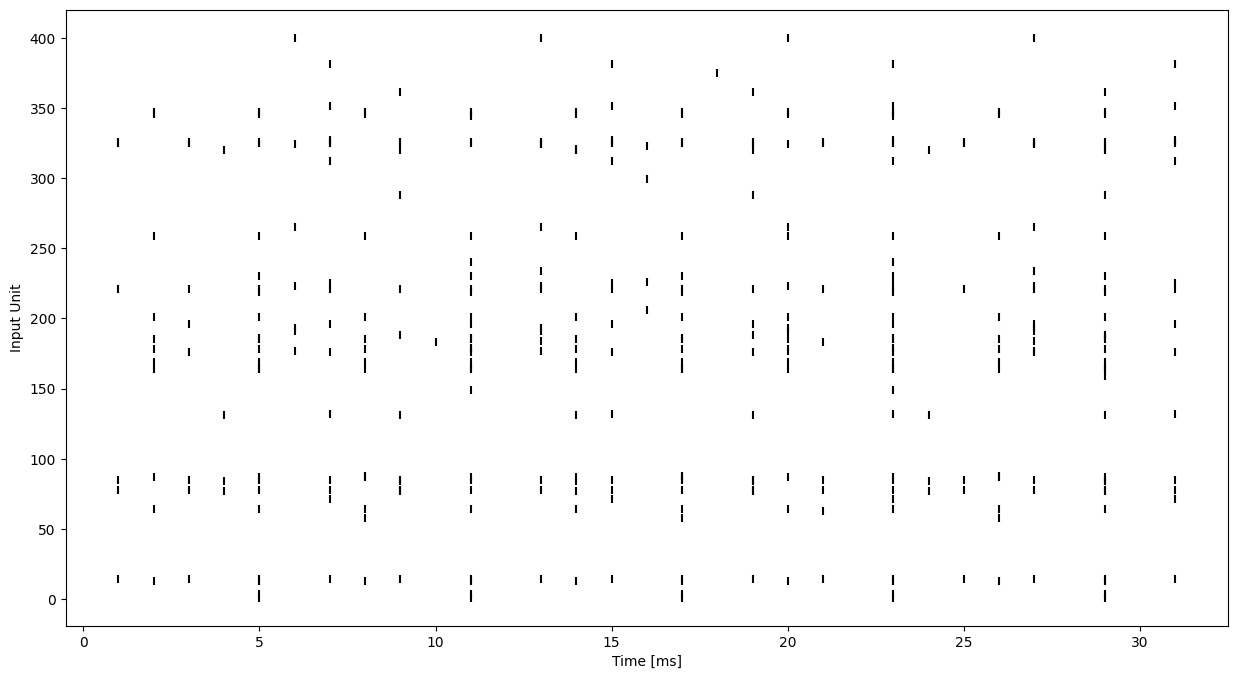

In [51]:
from norse.torch import ConstantCurrentLIFEncoder

constantcurrent_encoder = ConstantCurrentLIFEncoder(T)

example_input = constantcurrent_encoder(window_example)
example_spikes = example_input.reshape(T, window_example.shape[1] * window_example.shape[2]).to_sparse().coalesce()

t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.figure(figsize=(15, 8))
plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

## 2.2. `PoissonEncoder`

При использовании Пуассоновских процессов в качестве энкодера начальных данных важно понимать, что реальные нейроны не выдают одинаковый набор спайков при многократном предъявлении одной и той же постоянной стимуляции. Время между спайками распределено примерно по экспонциальному закону (что соответствует Пуассоновскому процессу), и это даёт естественную «шумовую» вариацию в дискретном представлении сигнала.

In [52]:
from norse.torch import PoissonEncoder

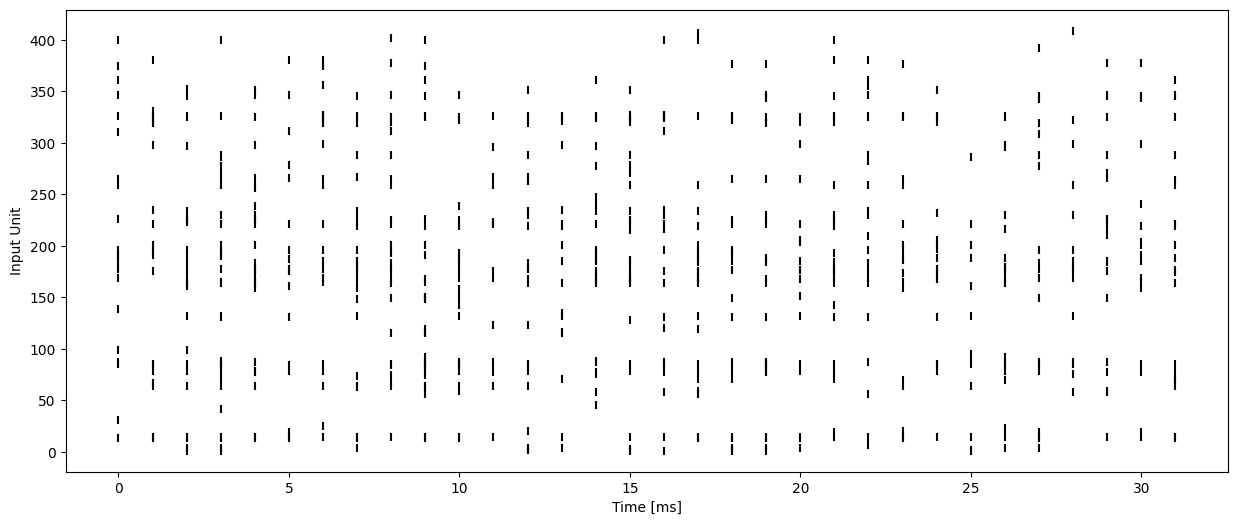

In [53]:
poisson_encoder = PoissonEncoder(T)

example_input = poisson_encoder(window_example)
example_spikes = example_input.reshape(T, window_example.shape[1] * window_example.shape[2]).to_sparse().coalesce()

t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.figure(figsize=(15, 6))
plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

## 2.3. `PopulationEncoder`

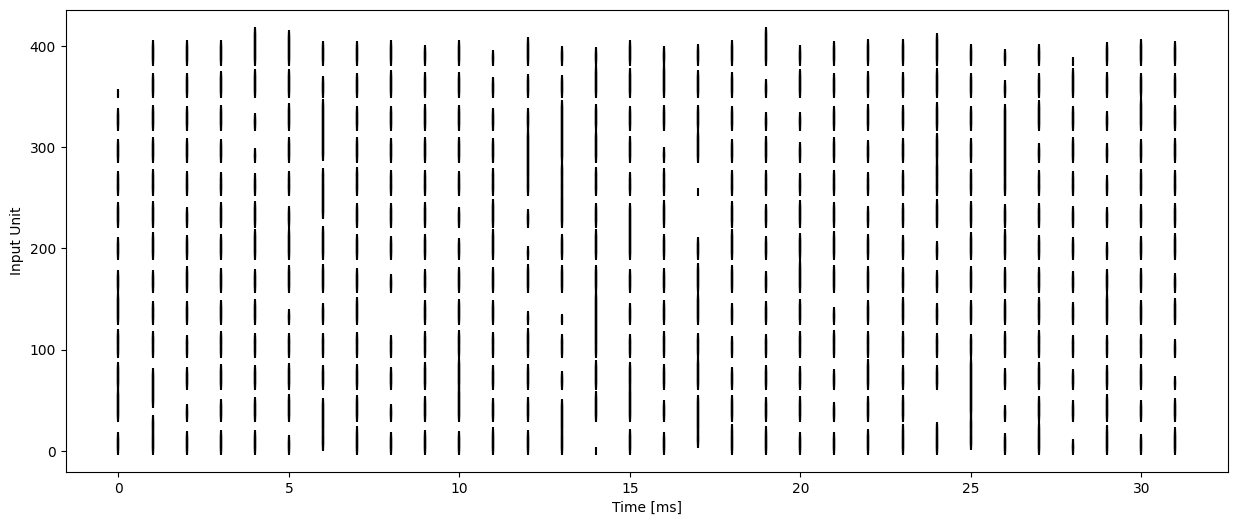

In [54]:
from norse.torch import PopulationEncoder

population_encoder = PopulationEncoder(T)

example_input = population_encoder(window_example)
example_spikes = example_input.reshape(T, window_example.shape[1] * window_example.shape[2]).to_sparse().coalesce()

t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.figure(figsize=(15, 6))
plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

## 3.4. SpikeLatencyLIFEncoder

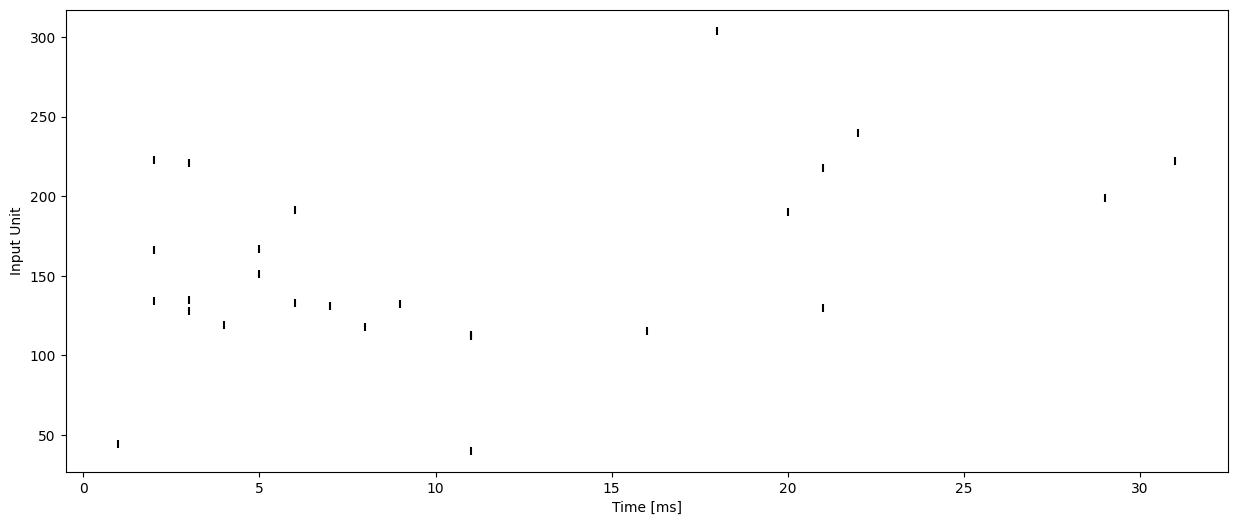

In [48]:
from norse.torch import SpikeLatencyLIFEncoder

latencyLIF_encoder = SpikeLatencyLIFEncoder(T)

example_input = latencyLIF_encoder(window_example)
example_spikes = example_input.reshape(T, window_example.shape[1] * window_example.shape[2]).to_sparse().coalesce()

t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.figure(figsize=(15, 6))
plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

# 3. Определение модели

Создаем общий класс модели, состоящий из энкодера, спайковой модели и декодера:

In [49]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

## 3.1. Спайковая модель

In [14]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(self, input_features, hidden_features, output_features, record=False, dt=0.001):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

## 3.2. Функции для декодирования спайков

In [15]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y    # ! Посмотреть в чем разница

In [16]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

## 3.3. Объединяем все в единую модель

In [17]:
T = 32
LR = 0.002
INPUT_FEATURES = window_example.shape[1] * window_example.shape[2]
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = len(GESTURE_INDEXES_MAIN)

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=PoissonEncoder(
        seq_length=T,
    ),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): PoissonEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=416, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=9, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

# 4. Обучение

In [ ]:
from tqdm.notebook import tqdm, trange

EPOCHS = 5  # Increase this number for better performance


def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [19]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [20]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []

torch.autograd.set_detect_anomaly(True)

for epoch in trange(EPOCHS):
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)

    print(accuracy)

print(f"final accuracy: {accuracies[-1]}")

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

56.87682570593963


  0%|          | 0/128 [00:00<?, ?it/s]

64.19182083739045


  0%|          | 0/128 [00:00<?, ?it/s]

65.44547224926971


  0%|          | 0/128 [00:00<?, ?it/s]

67.14946445959104


  0%|          | 0/128 [00:00<?, ?it/s]

66.8330087633885


  0%|          | 0/128 [00:00<?, ?it/s]

68.2935735150925


  0%|          | 0/128 [00:00<?, ?it/s]

68.05014605647517


  0%|          | 0/128 [00:00<?, ?it/s]

67.97711781888997


  0%|          | 0/128 [00:00<?, ?it/s]

68.13534566699124


  0%|          | 0/128 [00:00<?, ?it/s]

68.71957156767283


  0%|          | 0/128 [00:00<?, ?it/s]

69.29162609542357


  0%|          | 0/128 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

RuntimeError: view size is not compatible with input tensor's size and stride (at least one dimension spans across two contiguous subspaces). Use .reshape(...) instead.